WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


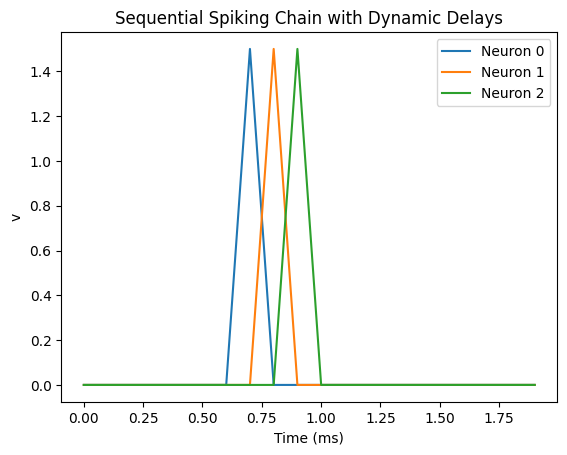

Input spike times: [0.6] ms
Neuron 0 spikes: [0.7] ms
Neuron 1 spikes: [0.8] ms
Neuron 2 spikes: [0.9] ms


In [1]:
from brian2 import *

start_scope()

# ======decay function here ======
eqs = '''
dv/dt = -v/tau : 1
tau : second
'''

# ====== Sigmoid delay function ======
@implementation('numpy', discard_units=True)
@check_units(w=1, t=1, layer=1, result=1)
def spike_arrival_delay(w, t, layer):
    print(t)
    return 1 / (1 + np.exp(-w * (t - layer)))

# ====== Parameters ======
initial_input = 0.6       # inital input -> spike time (ms)
w1 = 2.2                  # Weight for S1
w2 = -5.1                 # Weight for S2
input_weight = 1.5        # PSP amplitude

# ====== Neuron groups ======
G = NeuronGroup(3, eqs, threshold='v > 1', reset='v = 0', method='exact')
G.tau = 10*ms
G.v = 0

# ====== Input spike generator ======
input = SpikeGeneratorGroup(1, [0], [initial_input*ms])
input_syn = Synapses(input, G, on_pre='v_post += input_weight')
input_syn.connect(i=0, j=0)

# ====== Synapse model with delay calculation ======
syn_eqs = '''
w : 1
layer : 1
t_last : second
'''

on_pre_code = '''
temp_delay = 2 * ms # spike_arrival_delay(w, t/ms, layer) * ms
t_last = t
v_post += input_weight
'''

# ====== Neuron 0 → Neuron 1 (S1) ======
S1 = Synapses(G, G, model=syn_eqs, on_pre=on_pre_code)
S1.connect(i=0, j=1)
S1.w = w1
S1.layer = 1

# ====== Neuron 1 → Neuron 2 (S2) ======
S2 = Synapses(G, G, model=syn_eqs, on_pre=on_pre_code)
S2.connect(i=1, j=2)
S2.w = w2
S2.layer = 2

# ====== Monitors ======
M = StateMonitor(G, 'v', record=True)
spike_mon = SpikeMonitor(G)
input_mon = SpikeMonitor(input)

# ====== Run the simulation ======
run(2*ms)

# ====== Plot voltage traces ======
plot(M.t/ms, M.v[0], label='Neuron 0')
plot(M.t/ms, M.v[1], label='Neuron 1')
plot(M.t/ms, M.v[2], label='Neuron 2')
xlabel('Time (ms)')
ylabel('v')
title('Sequential Spiking Chain with Dynamic Delays')
legend()
show()

# ====== Print spike times ======
print("Input spike times:", input_mon.spike_trains()[0])
for i in range(3):
    print(f"Neuron {i} spikes: {spike_mon.spike_trains()[i]}")


WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: 'scheduled_time = ms * spike_timing(w, global_clock, layer)'
 [brian2.codegen.generators.base]


[0.41]
+ ===  [0.58569338]


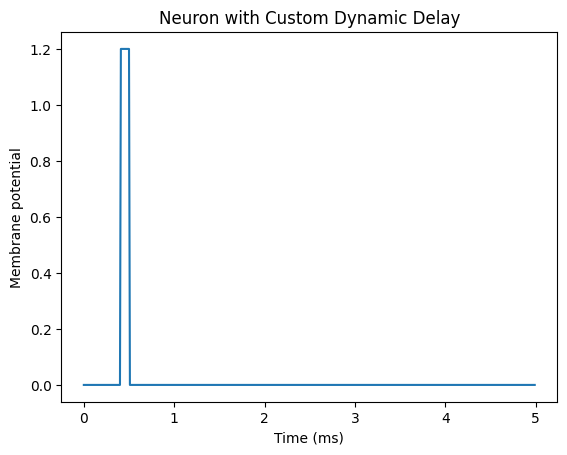

Spike times for neuron 0: [0.5] ms


In [158]:
from brian2 import *

start_scope()

# can remove layer if we know all within 1ms each layer 
@implementation('numpy', discard_units=True)
@check_units(w=1, global_clock=1, layer=1, result=1)
def spike_timing(w, global_clock, layer): 
    x = ((global_clock) % 1) 
    #layer_bias = int((t/ms)/2000)   # why by 200 not even a unit of bias ms --> mew seconds and such
    print(x)
    if not (0 <= x <= 1 and -1 <= w <= 1):
        raise ValueError("x must be in [0, 1] and w in [-1, 1]")
    if w >= 0:
        print("+ === ", layer + (x ** (1 - w)))
        return layer + (x ** (1 - w))
    else:
        print("- === ", layer + (1 - (1 - x) ** (1 + w)))
        return layer + (1 - (1 - x) ** (1 + w))
    



global_time = 0.0 # alreay to t var
input_val   = 0.4


#  ====== neuron gen here =========
neurons = NeuronGroup(1, '''
    v : 1
    scheduled_time : second
    global_clock : 1
''', threshold='v > 1', reset='v = 0', method='exact')
neurons.scheduled_time = 1e9 * second  # init with far-future
neurons.global_clock = 0.0   # will make new method but a pain to work out so useing this for now

# Spike generator
stim = SpikeGeneratorGroup(1, indices=[0], times=[input_val]*ms)




# Synapse
syn = Synapses(stim, neurons,
               '''
               w : 1
               layer : 1
               ''',
               on_pre='''
               scheduled_time = spike_timing(w, global_clock, layer) * ms
               ''')

syn.connect()
syn.w = 0.4
syn.layer = 0.0


# Apply effect when scheduled time arrives # the werid eq is just for rounding  if error and both 0 will it not fire?
neurons.run_regularly('''    
v = int(int(t / (0.1*ms)) == int(scheduled_time / (0.1*ms))) * 1.2
global_clock += 0.01
''', dt=0.01*ms)


# Monitor
mon = StateMonitor(neurons, 'v', record=True, dt=0.01*ms)
spikemon = SpikeMonitor(neurons)

run(5*ms)

# Plot
plot(mon.t/ms, mon.v[0])
xlabel('Time (ms)')
ylabel('Membrane potential')
title('Neuron with Custom Dynamic Delay')
show()

# Print spike times
print("Spike times for neuron 0:", spikemon.spike_trains()[0])
# Or equivalently:
#print("All spike times:", spikemon.t)
# print("Neuron indices:", spikemon.i)


In [27]:
from brian2 import *

start_scope()

# Define a simple neuron group
G = NeuronGroup(1, 'dv/dt = (1-v)/ms : 1', threshold='v>0.9', reset='v=0', method='exact')
G.v = 0

# Monitor spikes
spikemon = SpikeMonitor(G)

# Run the simulation
run(5*ms)

# Print spike times
print("Spike times for neuron 0:", spikemon.spike_trains()[0])
# Or equivalently:
print("All spike times:", spikemon.t)
print("Neuron indices:", spikemon.i)


Spike times for neuron 0: [2.3  4.61] ms
All spike times: <spikemonitor_22.t: array([2.3 , 4.61]) * msecond>
Neuron indices: <spikemonitor_22.i: array([0, 0])>


In [27]:

time = 2.7

k = time % 1  # will give you

j = int(time)


print(k)

print(j)

0.7000000000000002
2
